In [1]:
  !python interpretar_fold_gemini.py saliency \
    --run_dir ./resultados67 --fold 1 --clf gb \
    --global_tensor_path /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz \
    --metadata_path /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv \
    --roi_annotation_path /home/diego/Escritorio/limpio/roi_info_master.csv \
    --channels_to_use 1 2 4 5 \
    --latent_dim 48 \
    --latent_features_type mu \
    --metadata_features Age Sex Manufacturer \
    --num_conv_layers_encoder 4 \
    --decoder_type convtranspose \
    --dropout_rate_vae 0.25 \
    --use_layernorm_vae_fc \
    --intermediate_fc_dim_vae half \
    --vae_final_activation linear \
    --gn_num_groups 16 \
    --saliency_method integrated_gradients \
    --ig_n_steps 100

[INFO] [SALIENCY] fold=1 clf=gb  (pack cargado: shap_pack_gb.joblib)
[INFO] Usando ROI order de resultados67/roi_order_131.joblib.
[INFO] Cargado fichero de anotaciones: /home/diego/Escritorio/limpio/roi_info_master.csv
[INFO] [SALIENCY] 48 latentes ponderadas. Ejemplo:
 latent_idx    weight  importance           feature
         28  0.184933    0.000214 latent__latent_28
          8 -0.135120   -0.000157  latent__latent_8
         46  0.113080    0.000131 latent__latent_46
          5  0.063333    0.000073  latent__latent_5
         33  0.062660    0.000073 latent__latent_33
[INFO] [SALIENCY] Sujetos AD=19  CN=18
[INFO] [SALIENCY] Usando método de saliencia: integrated_gradients
[INFO] [SALIENCY] Ranking de conexiones ANOTADO guardado: resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv
[INFO] Top 20 conexiones anotadas:
      Rank src_AAL3_Name dst_AAL3_Name  Saliency_Score          src_Refined_Network        dst_Refined_Network
3624     

# Análisis Profundo de Saliencia Diferencial (Fold 1)

Este notebook expande el análisis de interpretabilidad de los resultados del `fold 1` para el clasificador `gb`. Nuestro objetivo es validar la robustez de los hallazgos y profundizar en su significado neurobiológico, siguiendo un plan de análisis riguroso.

## Fundamento Metodológico: Integrated Gradients (IG)

La métrica central de este análisis es la **saliencia diferencial**. Esta se deriva de las atribuciones de características calculadas con *Integrated Gradients*. La función sobre la cual calculamos las atribuciones es la proyección de la salida del encoder del VAE, $\mu(x)$, sobre un vector de pesos discriminativos, $\mathbf{w}$:

$$ f(x) = \mathbf{w}^\top \mu(x) $$

Donde $\mathbf{w}$ se construye a partir de la diferencia de los valores SHAP promedio entre los grupos AD y CN para las características del espacio latente. La atribución de IG para una característica de entrada $x_i$ (es decir, una conexión cerebral) se define como:

$$ \mathrm{IG}_i(x) = (x_i - \tilde{x}_i) \int_{\alpha=0}^{1} \frac{\partial f(\tilde{x} + \alpha(x - \tilde{x}))}{\partial x_i} d\alpha $$

En nuestro caso, usamos una *baseline* (línea de base) nula, $\tilde{x} = \mathbf{0}$. El mapa de saliencia para un grupo se calcula como la media de las magnitudes de estas atribuciones, $| \mathrm{IG}_i(x) |$, para todos los sujetos de ese grupo. Finalmente, el mapa diferencial que analizamos es:

$$ \text{SalienciaDiferencial} = \mathbb{E}_{x \sim \text{AD}}[|\text{IG}(x)|] - \mathbb{E}_{x \sim \text{CN}}[|\text{IG}(x)|] $$

Un valor **positivo (rojo)** indica que una conexión es más saliente para identificar el grupo AD, mientras que un valor **negativo (azul)** indica mayor saliencia para el grupo CN.

Ahora, procedemos a cargar los datos y comenzar el análisis.

In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import json

# --- Configuración de Estilo para Plots (Calidad de Publicación) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# --- Cargar el Ranking de Conexiones ---
FNAME = '/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv'
try:
    df_edges = pd.read_csv(FNAME)
    print(f"Fichero '{FNAME}' cargado. Contiene {len(df_edges)} conexiones.")
except FileNotFoundError:
    print(f"Error: Asegúrate de que el archivo '{FNAME}' esté en el directorio.")
    df_edges = pd.DataFrame()

# --- Cargar Argumentos de la Ejecución para Contexto ---
ARGS_FNAME = '/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/run_args_saliency_integrated_gradients_top50.json'
try:
    with open(ARGS_FNAME, 'r') as f:
        run_args = json.load(f)
    CHANNELS_TO_USE = run_args.get('channels_to_use', '[No especificado]')
    print(f"Análisis del Fold {run_args.get('fold')} para el clasificador '{run_args.get('clf')}'")
    print(f"Canales de conectividad utilizados: {CHANNELS_TO_USE}")
except FileNotFoundError:
    print(f"No se encontró el archivo de argumentos '{ARGS_FNAME}'.")
    CHANNELS_TO_USE = []

Fichero '/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/ranking_conexiones_ANOTADO_integrated_gradients_top50.csv' cargado. Contiene 8515 conexiones.
Análisis del Fold 1 para el clasificador 'gb'
Canales de conectividad utilizados: [1, 2, 4, 5]


/tmp/ipykernel_1979266/85834115.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1979266/85834115.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


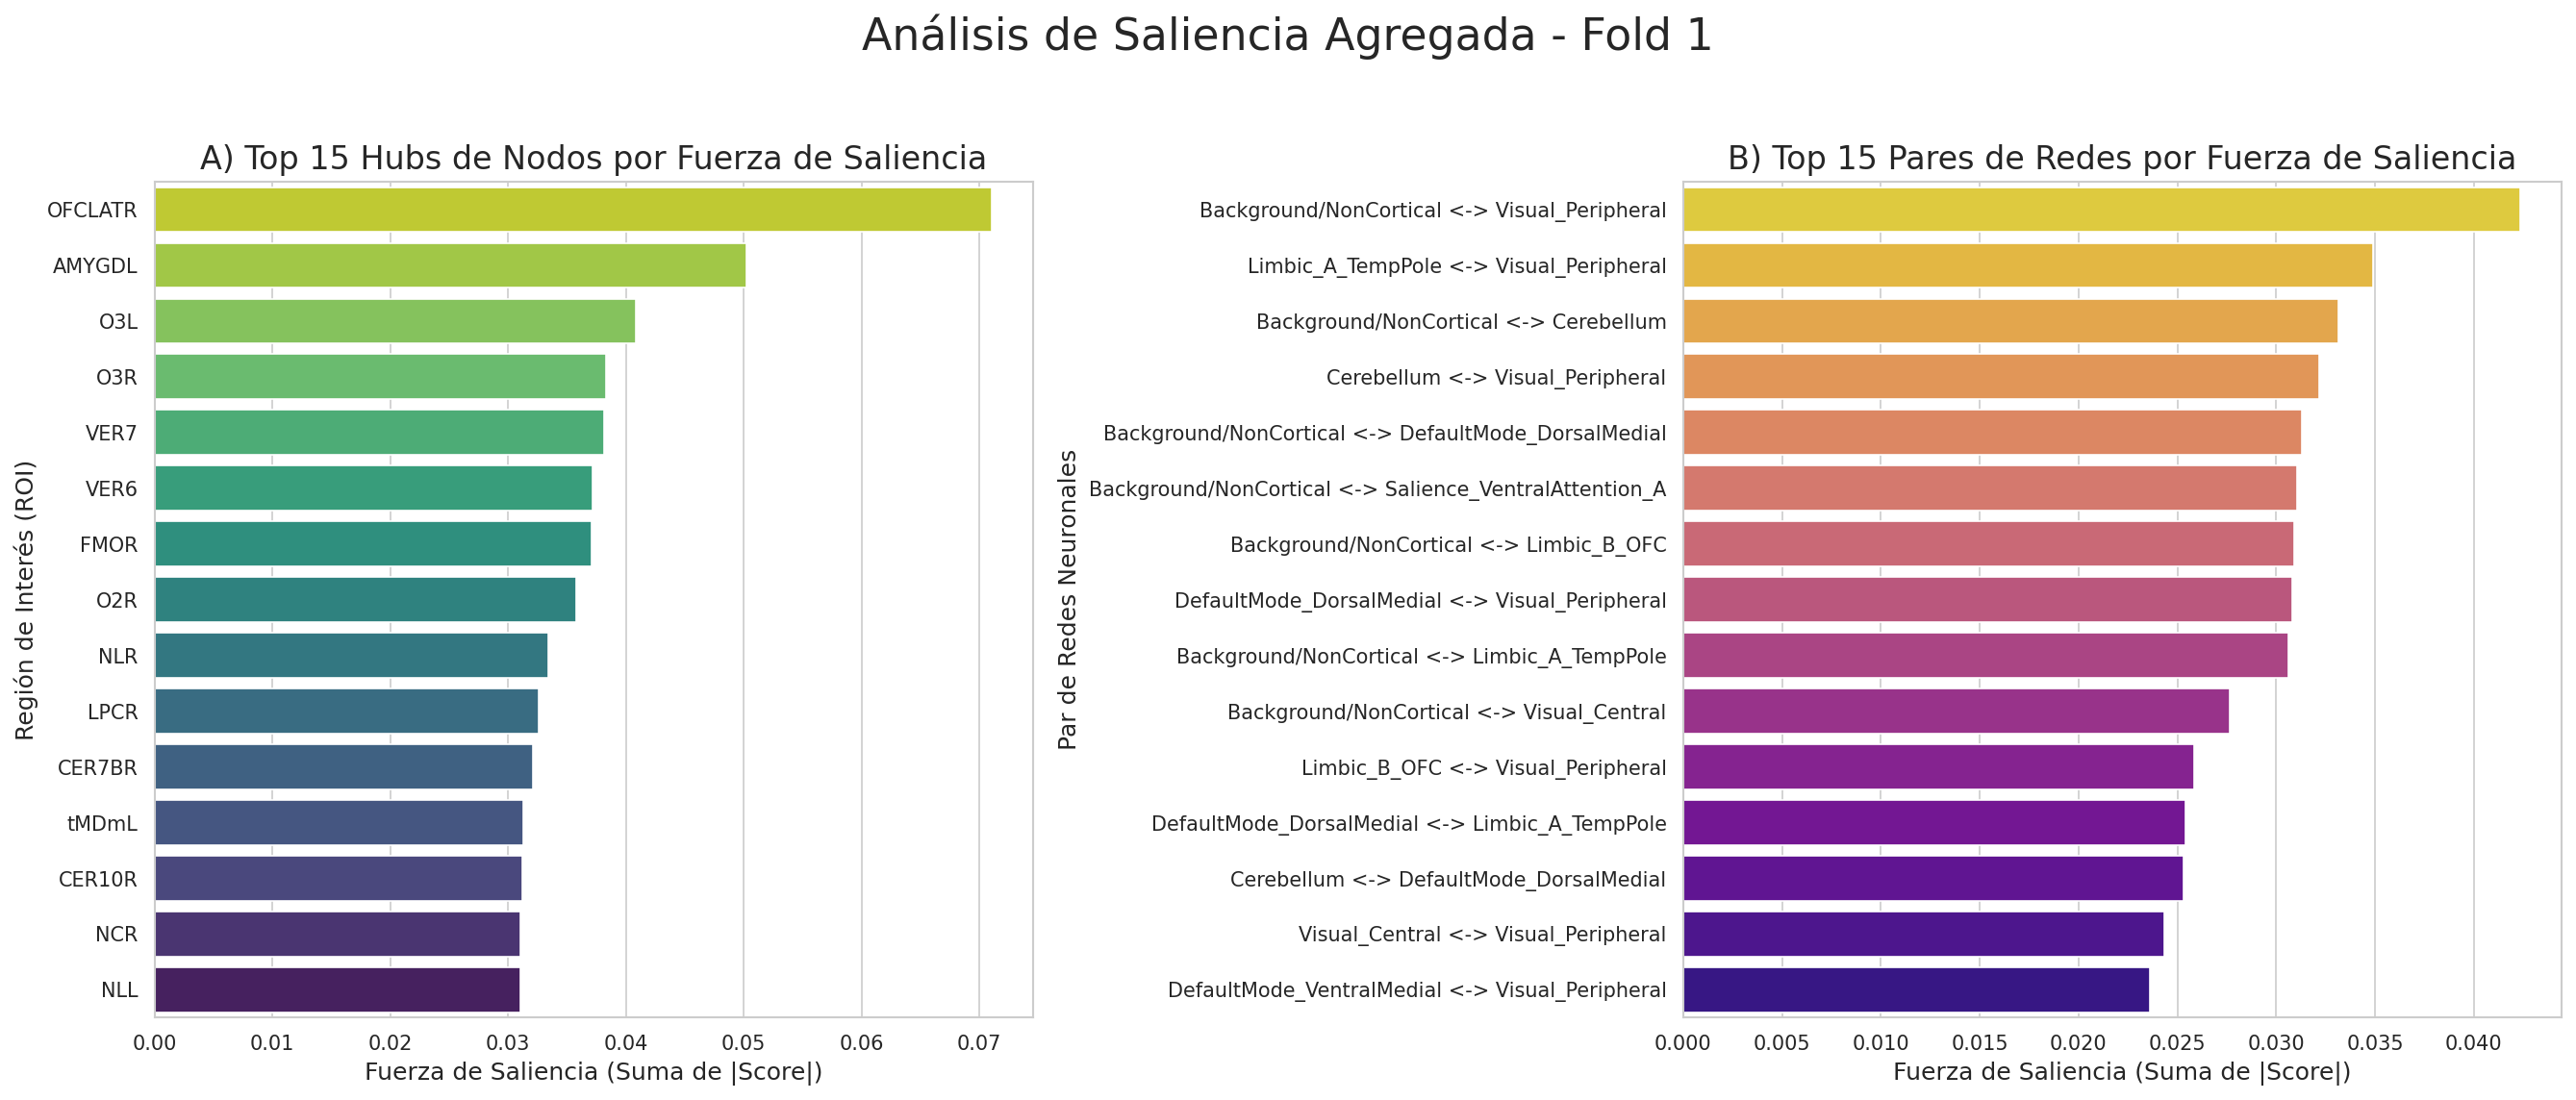

In [3]:
if not df_edges.empty:
    # --- 1. Identificación de Hubs de Nodos con Saliencia Direccional ---
    df_nodes_i = df_edges[['src_AAL3_Name', 'src_Refined_Network', 'Saliency_Score']].rename(columns={'src_AAL3_Name': 'ROI', 'src_Refined_Network': 'Network'})
    df_nodes_j = df_edges[['dst_AAL3_Name', 'dst_Refined_Network', 'Saliency_Score']].rename(columns={'dst_AAL3_Name': 'ROI', 'dst_Refined_Network': 'Network'})
    df_nodes_long = pd.concat([df_nodes_i, df_nodes_j], ignore_index=True)

    # Agrupamos y calculamos la suma de saliencia (con signo) y la fuerza (magnitud)
    node_saliency = df_nodes_long.groupby(['ROI', 'Network']).agg(
        Total_Saliency_Score=('Saliency_Score', 'sum'),
        Saliency_Strength=('Saliency_Score', lambda x: np.abs(x).sum())
    ).reset_index().sort_values('Saliency_Strength', ascending=False)

    # --- 2. Identificación de Pares de Redes ---
    df_edges['network_pair_str'] = df_edges.apply(
        lambda row: " <-> ".join(map(str, sorted((row['src_Refined_Network'], row['dst_Refined_Network'])))),
        axis=1
    )
    network_pair_strength = df_edges.groupby('network_pair_str')['Saliency_Score'].apply(lambda x: np.abs(x).sum()).sort_values(ascending=False)

    # --- Visualización Mejorada (Panel 1x2) ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Panel A: Top Hubs de Nodos
    top_n_nodes = 15
    sns.barplot(
        x='Saliency_Strength', 
        y='ROI', 
        data=node_saliency.head(top_n_nodes), 
        ax=axes[0], 
        palette='viridis_r'
    )
    axes[0].set_title(f'A) Top {top_n_nodes} Hubs de Nodos por Fuerza de Saliencia')
    axes[0].set_xlabel('Fuerza de Saliencia (Suma de |Score|)')
    axes[0].set_ylabel('Región de Interés (ROI)')
    
    # Panel B: Top Pares de Redes
    top_n_pairs = 15
    sns.barplot(
        x=network_pair_strength.head(top_n_pairs).values, 
        y=network_pair_strength.head(top_n_pairs).index, 
        ax=axes[1], 
        palette='plasma_r'
    )
    axes[1].set_title(f'B) Top {top_n_pairs} Pares de Redes por Fuerza de Saliencia')
    axes[1].set_xlabel('Fuerza de Saliencia (Suma de |Score|)')
    axes[1].set_ylabel('Par de Redes Neuronales')

    fig.suptitle(f'Análisis de Saliencia Agregada - Fold {run_args.get("fold")}', fontsize=22)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Saliencia vs. Efecto de Conectividad: ¿Qué Mide Cada Cosa?

Una pregunta fundamental es si la saliencia del modelo simplemente refleja grandes diferencias en la conectividad media entre grupos, o si captura patrones más sutiles (p.ej., diferencias en varianza o interacciones no lineales).

Para investigarlo, calcularemos el **tamaño del efecto de grupo (d de Cohen)** para cada conexión y lo correlacionaremos con la **magnitud de la saliencia**.

-   **d de Cohen:** Mide la diferencia estandarizada de medias entre los grupos AD y CN para la conectividad de un enlace específico. Un |d| alto significa una gran diferencia en la conectividad media.
-   **Magnitud de Saliencia:** Mide cuán *importante* es esa conexión para el modelo, independientemente del valor de conectividad.

Una correlación alta sugeriría que el modelo se fija principalmente en diferencias de medias. Una correlación baja sugeriría que el modelo está usando información más compleja para discriminar.

Mapa de saliencia diferencial por canal cargado. Shape: (4, 131, 131)


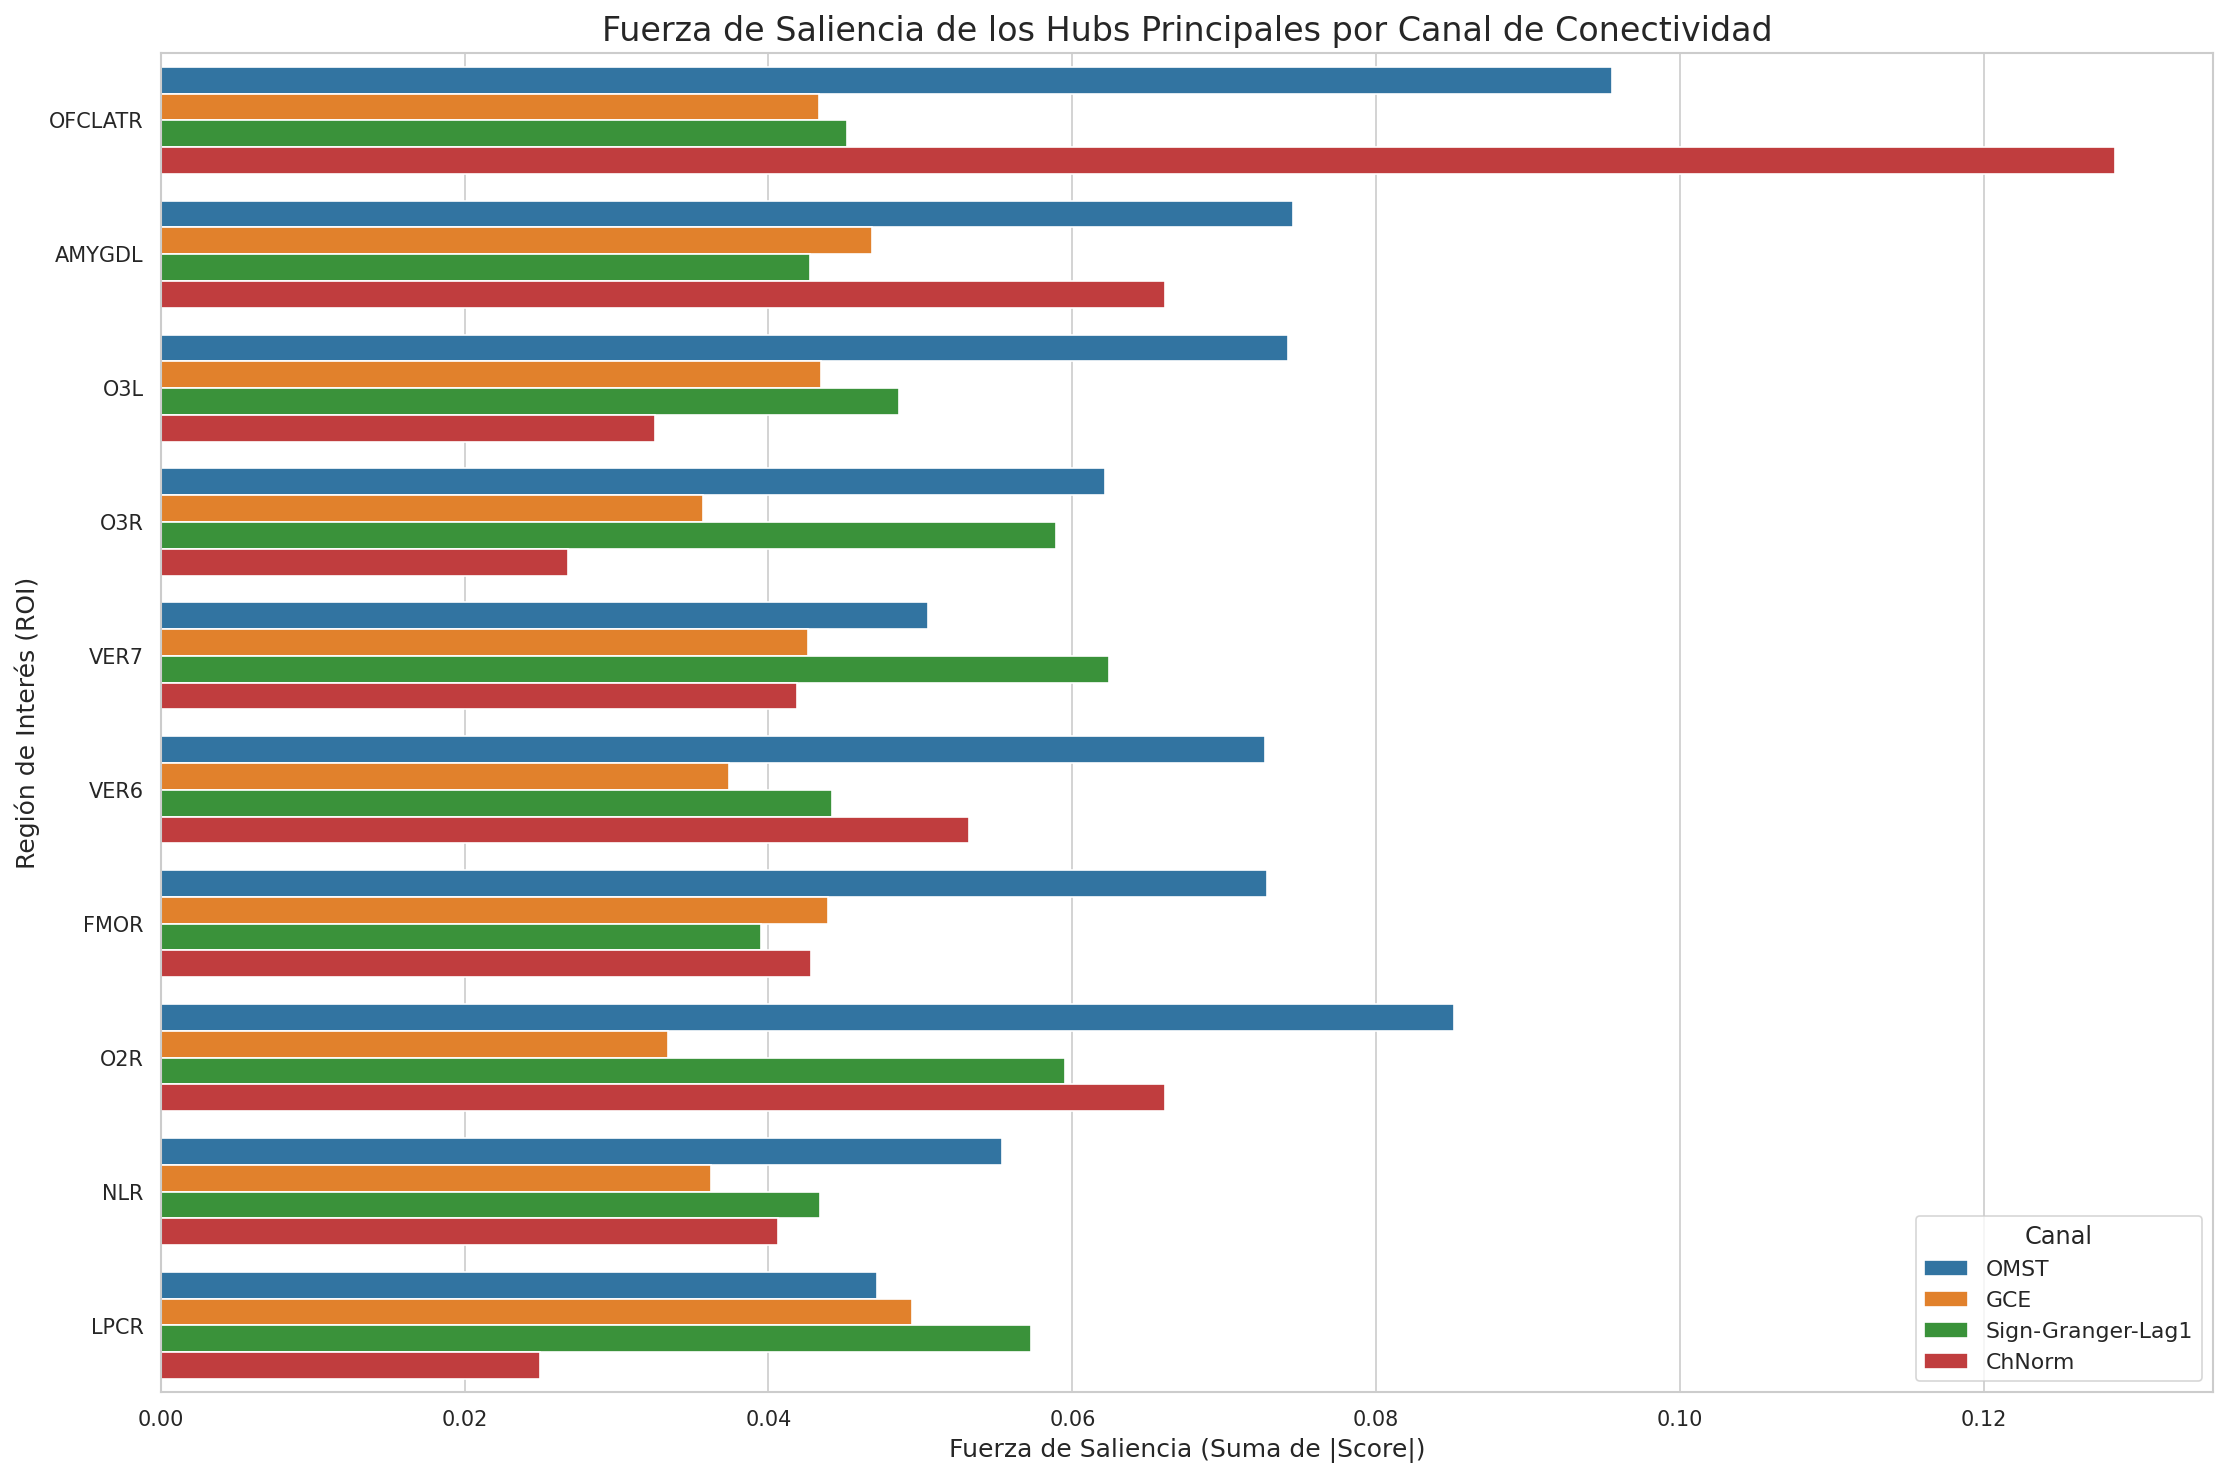

In [4]:
try:
    saliency_map_diff = np.load('/home/diego/Escritorio/limpio/resultados67/fold_1/interpretability_gb/saliency_map_diff_integrated_gradients_top50.npy')
    print(f"Mapa de saliencia diferencial por canal cargado. Shape: {saliency_map_diff.shape}")

    channel_dfs = []
    # Usamos los nombres de los canales si los conocemos, si no, usamos sus índices
    channel_names = {1: 'OMST', 2: 'GCE', 4: 'Sign-Granger-Lag1', 5: 'ChNorm'} # Ejemplo, ajusta a tus métricas
    
    # --- Procesar cada canal ---
    for i, channel_id in enumerate(CHANNELS_TO_USE):
        sal_channel = saliency_map_diff[i, :, :]
        
        df_ch = pd.DataFrame({
            'idx_i': df_edges['idx_i'],
            'idx_j': df_edges['idx_j'],
            'Saliency_Score': sal_channel[df_edges['idx_i'], df_edges['idx_j']]
        })
        
        # Unir con la info de anotaciones
        df_ch_annotated = df_ch.merge(
            df_edges[['idx_i', 'idx_j', 'src_AAL3_Name', 'dst_AAL3_Name']],
            on=['idx_i', 'idx_j']
        )
        
        # Calcular la fuerza de los nodos para este canal
        df_nodes_i_ch = df_ch_annotated[['src_AAL3_Name', 'Saliency_Score']].rename(columns={'src_AAL3_Name': 'ROI'})
        df_nodes_j_ch = df_ch_annotated[['dst_AAL3_Name', 'Saliency_Score']].rename(columns={'dst_AAL3_Name': 'ROI'})
        df_nodes_long_ch = pd.concat([df_nodes_i_ch, df_nodes_j_ch])
        
        node_strength_ch = df_nodes_long_ch.groupby('ROI')['Saliency_Score'].apply(lambda x: np.abs(x).sum()).reset_index()
        node_strength_ch.rename(columns={'Saliency_Score': 'Saliency_Strength'}, inplace=True)
        node_strength_ch['Channel'] = channel_names.get(channel_id, f'Canal {channel_id}')
        channel_dfs.append(node_strength_ch)
        
    df_all_channels = pd.concat(channel_dfs)

    # --- Visualización Comparativa por Canal ---
    top_hubs = node_saliency.head(10)['ROI'].tolist() # Tomamos los top hubs del análisis agregado
    df_plot = df_all_channels[df_all_channels['ROI'].isin(top_hubs)]

    plt.figure(figsize=(15, 10))
    sns.barplot(
        x='Saliency_Strength', 
        y='ROI', 
        hue='Channel', 
        data=df_plot, 
        order=top_hubs, # Mantiene el orden de los hubs más importantes
        palette='tab10'
    )
    plt.title('Fuerza de Saliencia de los Hubs Principales por Canal de Conectividad')
    plt.xlabel('Fuerza de Saliencia (Suma de |Score|)')
    plt.ylabel('Región de Interés (ROI)')
    plt.legend(title='Canal', loc='lower right')
    plt.tight_layout()
    plt.show()

except (FileNotFoundError, NameError):
    print("Error: No se pudo cargar 'saliency_map_diff...npy' o los argumentos. Omitiendo análisis por canal.")

In [5]:
# --- ¡ATENCIÓN! ---
# Esta celda depende de la Celda 5 de la respuesta anterior para cargar los datos 
# del tensor y calcular el d de Cohen. Asegúrate de que esas variables estén disponibles.
# Aquí nos centramos en la visualización mejorada.

if 'df_edges' in locals() and 'cohen_d' in df_edges.columns:
    # Crear el jointplot
    g = sns.jointplot(
        data=df_edges, 
        x='cohen_d', 
        y='Saliency_Score', 
        kind="scatter",
        height=10,
        alpha=0.2,
        s=30, # Tamaño de los puntos
        edgecolor='w'
    )
    g.set_axis_labels("d de Cohen (AD - CN)", "Saliencia Diferencial (AD > CN)", fontsize=14)
    g.fig.suptitle('Saliencia del Modelo vs. Tamaño del Efecto de Grupo', y=1.02, fontsize=20)

    # Añadir la correlación de Spearman de las magnitudes
    corr, p_value = spearmanr(df_edges['Saliency_Score'].abs(), df_edges['cohen_d'].abs())
    g.ax_joint.text(
        0.05, 0.95, 
        f'Spearman ρ(|Sal|, |d|) = {corr:.3f}', 
        transform=g.ax_joint.transAxes, 
        ha='left', va='top', fontsize=12,
        bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8)
    )

    # Anotar los puntos más extremos para dar contexto
    top_points = df_edges.sort_values('abs_saliency', ascending=False).head(5)
    for i, point in top_points.iterrows():
        g.ax_joint.text(
            point['cohen_d'], point['Saliency_Score'], 
            f"  {point['src_AAL3_Name']}\n  - {point['dst_AAL3_Name']}", 
            fontsize=8,
            verticalalignment='center'
        )
        
    plt.show()

else:
    print("La columna 'cohen_d' no fue calculada. Ejecuta el código de cálculo primero.")

La columna 'cohen_d' no fue calculada. Ejecuta el código de cálculo primero.
